## Loan Interest Rate Prediction Project

### Project Summary
This project aims to analyze the various borrower information and build machine learning models to predict the interest rate assigned to the loan.

### Data
This borrower information dataset has 32 variables and 399999 observations.

### Project Sections
1. EDA & Feature Engineering

2. Model Building & Selection
  - Ridge
  - KNN
  - Gradient Boosting

3. Model Evaluation

4. Prediction

### Author & Platform
Yezi Liu conducted this project independently in Visual Studio Code.

## Connect GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 15 03:13:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load Packages

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

## Set Up Environmental Variables

In [ ]:
DATA_PATH = 'Data for Cleaning _ Modeling.csv'

## Data Import

In [ ]:
df = pd.read_csv(DATA_PATH)
df.head()

<ipython-input-9-80c6175270f5>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data for Cleaning _ Modeling.csv')


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
0,11.89%,54734.0,80364.0,"$25,000","$25,000","$19,080",36 months,B,B4,NaN,...,Feb-94,0.0,NaN,NaN,10.0,0.0,28854.0,52.10%,42.0,f
1,10.71%,55742.0,114426.0,"$7,000","$7,000",$673,36 months,B,B5,CNN,...,Oct-00,0.0,NaN,NaN,7.0,0.0,33623.0,76.70%,7.0,f
2,16.99%,57167.0,137225.0,"$25,000","$25,000","$24,725",36 months,D,D3,Web Programmer,...,Jun-00,0.0,41.0,NaN,10.0,0.0,19878.0,66.30%,17.0,f
3,13.11%,57245.0,138150.0,"$1,200","$1,200","$1,200",36 months,C,C2,city of beaumont texas,...,Jan-85,0.0,64.0,NaN,5.0,0.0,2584.0,40.40%,31.0,f
4,13.57%,57416.0,139635.0,"$10,800","$10,800","$10,692",36 months,C,C3,State Farm Insurance,...,Dec-96,1.0,58.0,NaN,14.0,0.0,3511.0,25.60%,40.0,f


### **Data Dictionary**

X1: Interest Rate on the loan

X2: A unique id for the loan

X3: A unique id assigned for the borrower

X4: Loan amount requested

X5: Loan amount funded

X6: Investor-funded portion of loan

X7: Number of payments (36 or 60)

X8: Loan grade

X9: Loan subgrade

X10: Employer or job title (self-filled)

X11: Number of years employed (0 to 10; 10 = 10 or more)

X12: Home ownership status: RENT, OWN, MORTGAGE, OTHER.

X13: Annual income of borrower

X14: Income verified, not verified, or income source was verified

X15: Date loan was issued

X16: Reason for loan provided by borrower

X17: Loan category, as provided by borrower

X18: Loan title, as provided by borrower

X19: First 3 numbers of zip code

X20: State of borrower

X21: A ratio calculated using the borrower's total monthly debt payments on the total debt obligations, excluding mortgage and the requested loan, divided by the borrower's self-reported monthly income

X22: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

X23: Date the borrower's earliest reported credit line was opened

X24: Number of inquiries by creditors during the past 6 months

X25: Number of months since the borrower's last delinquency

X26: Number of months since the last public record

X27: Number of open credit lines in the borrower's credit file

X28: Number of derogatory public records

X29: Total credit revolving balance

X30: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

X31: The total number of credit lines currently in the borrower's credit file

X32: The initial listing status of the loan. Possible values are W and F

## EDA & Feature Engineering

In [ ]:
# Function used for this section
def map_years_employed_to_category(years):
    """
    This function groups the values in the column into three general categories
    while dealing with possible null values as well.
    """
    if years in ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years']:
        return '5 years or less'
    elif years in ['6 years', '7 years', '8 years', '9 years']:
        return '5 years to 10 years'
    elif years == '10+ years':
        return '10+ years'
    else:
        return 'Unknown'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X1      338990 non-null  object 
 1   X2      399999 non-null  float64
 2   X3      399999 non-null  float64
 3   X4      399999 non-null  object 
 4   X5      399999 non-null  object 
 5   X6      399999 non-null  object 
 6   X7      399999 non-null  object 
 7   X8      338730 non-null  object 
 8   X9      338730 non-null  object 
 9   X10     376014 non-null  object 
 10  X11     382462 non-null  object 
 11  X12     338639 non-null  object 
 12  X13     338972 non-null  float64
 13  X14     399999 non-null  object 
 14  X15     399999 non-null  object 
 15  X16     123560 non-null  object 
 16  X17     399999 non-null  object 
 17  X18     399981 non-null  object 
 18  X19     399999 non-null  object 
 19  X20     399999 non-null  object 
 20  X21     399999 non-null  float64
 21  X22     39

### X16 feature engineering

For variable X16(Reason for loan provided by borrower), there are too many missing values(only 30% are non-null values out of 400000), and it's long text data, which is really challenging to create synthetic data to fullfill its null values.

I decided to turn this column into a binary column named 'Provided loan reasons' where it's 1 if there are text values and 0 when it's null or blank. By doing this, I simplified this column while keeping as much information as possible.

In [ ]:
# Replace blank strings and purely whitespace strings with NaN using regex
df['X16'] = df['X16'].replace(r'^\s*$', np.nan, regex=True)

# Convert the 'Reason for the loan' column into a binary 'Provided loan reasons' column
df['Provided loan reasons'] = np.where(df['X16'].isna(), 0, 1)
df.drop('X16', axis=1, inplace=True)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,X26,X27,X28,X29,X30,X31,X32,Provided loan reasons
0,11.89%,54734.0,80364.0,"$25,000","$25,000","$19,080",36 months,B,B4,NaN,...,0.0,NaN,NaN,10.0,0.0,28854.0,52.10%,42.0,f,1
1,10.71%,55742.0,114426.0,"$7,000","$7,000",$673,36 months,B,B5,CNN,...,0.0,NaN,NaN,7.0,0.0,33623.0,76.70%,7.0,f,1
2,16.99%,57167.0,137225.0,"$25,000","$25,000","$24,725",36 months,D,D3,Web Programmer,...,0.0,41.0,NaN,10.0,0.0,19878.0,66.30%,17.0,f,1
3,13.11%,57245.0,138150.0,"$1,200","$1,200","$1,200",36 months,C,C2,city of beaumont texas,...,0.0,64.0,NaN,5.0,0.0,2584.0,40.40%,31.0,f,1
4,13.57%,57416.0,139635.0,"$10,800","$10,800","$10,692",36 months,C,C3,State Farm Insurance,...,1.0,58.0,NaN,14.0,0.0,3511.0,25.60%,40.0,f,1


In [ ]:
print(df['Provided loan reasons'].value_counts())

0    276660
1    123340
Name: Provided loan reasons, dtype: int64


### X25 feature engineering

The X25 column(Number of months since the borrower's last delinquency) has so many missing values(181198 non-null values out of 400000), but it's an important column to predict loan interest rate, so I didn't remove it.

Instead, I reasonably converted the null values into "No delinquency" category(assuming null values mean that this borrower doesn't have delinquencies in the past). And I converted the numerical months into 3 ordered categories based on quantiles: 'Very recent', 'Some time ago', and 'Long time ago'. As a result, I turned this X25 column into a ordered categorical variable called 'delinquency_recency' with 4 categories.

In [ ]:
# Define the categories, including 'No delinquency'
X25_categories = ['Very recent', 'Some time ago', 'Long time ago', 'No delinquency']

# Use pd.qcut on the non-null values to categorize them
# Temporarily exclude null values by using dropna=False and later fill these with 'No delinquency'
df['delinquency_recency'] = pd.qcut(df['X25'].dropna(),
                                     q=3,
                                     labels=X25_categories[:-1])  # Exclude 'No delinquency' for this operation

# Convert to categorical and explicitly define all categories, including 'No delinquency'
df['delinquency_recency'] = pd.Categorical(df['delinquency_recency'], categories=X25_categories, ordered=True)

# Fill NA values in the new column with 'No delinquency'
df['delinquency_recency'].fillna('No delinquency', inplace=True)

# Drop the original column
df.drop('X25', axis=1, inplace=True)

In [ ]:
print(df['delinquency_recency'].value_counts())

No delinquency    218802
Some time ago      61249
Very recent        60689
Long time ago      59260
Name: delinquency_recency, dtype: int64


### X26 feature engineering

The X26 column(Number of months since the last public record) has so many missing values(51155 non-null values out of 400000), but it's an important column to predict loan interest rate, so I didn't remove it.

Instead, I reasonably converted the null values into "No public record" category(assuming null values mean that this borrower doesn't have any public record in the past). And I converted the numerical months into 3 ordered categories based on quantiles: 'Very recent', 'Some time ago', and 'Long time ago'. As a result, I turned this X26 column into a ordered categorical variable called 'public_record_recency' with 4 categories.

In [ ]:
# Define the categories, including 'No public record'
public_record_categories = ['Very recent', 'Some time ago', 'Long time ago', 'No public record']

# Use pd.qcut on the non-null values to categorize them
# Temporarily exclude null values by using dropna() and later fill these with 'No public record'
df['public_record_recency'] = pd.qcut(df['X26'].dropna(),
                                       q=3,
                                       labels=public_record_categories[:-1])  # Exclude 'No public record' for this operation

# Convert to categorical and explicitly define all categories, including 'No public record'
df['public_record_recency'] = pd.Categorical(df['public_record_recency'], categories=public_record_categories, ordered=True)

# Fill NA values in the new column with 'No public record'
df['public_record_recency'].fillna('No public record', inplace=True)

# Drop the original column
df.drop('X26', axis=1, inplace=True)

print(df['public_record_recency'].value_counts())

No public record    348845
Very recent          17306
Some time ago        17102
Long time ago        16747
Name: public_record_recency, dtype: int64


### Drop other blank/null values

In [ ]:
# Replace blank values with NaN
# This replaces both empty strings and strings with only whitespace
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Drop rows with NaN values
# This will drop any row that contains at least one NaN value
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193248 entries, 1 to 399998
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   X1                     193248 non-null  object  
 1   X2                     193248 non-null  float64 
 2   X3                     193248 non-null  float64 
 3   X4                     193248 non-null  object  
 4   X5                     193248 non-null  object  
 5   X6                     193248 non-null  object  
 6   X7                     193248 non-null  object  
 7   X8                     193248 non-null  object  
 8   X9                     193248 non-null  object  
 9   X10                    193248 non-null  object  
 10  X11                    193248 non-null  object  
 11  X12                    193248 non-null  object  
 12  X13                    193248 non-null  float64 
 13  X14                    193248 non-null  object  
 14  X15                 

### Drop obviously irrelevant features

Since loan grade and loan subgrade are highly correlated and similar, I decided to drop loan subgrade for simplicity.

**Dropped columns:**

X2: A unique id for the loan

X3: A unique id assigned for the borrower

X9: Loan subgrade

X15: Date loan was issued

X19: First 3 numbers of zip code


In [ ]:
df = df.drop(['X2', 'X3', 'X9', 'X15', 'X19'], axis=1)
df.head()

,X1,X4,X5,X6,X7,X8,X10,X11,X12,X13,X14,X17,X18,X20,X21,X22,X23,X24,X27,X28,X29,X30,X31,X32,Provided loan reasons,delinquency_recency,public_record_recency
1,10.71%,"$7,000","$7,000",$673,36 months,B,CNN,< 1 year,RENT,65000.0,not verified,credit_card,Credit Card payoff,NY,14.29,0.0,Oct-00,0.0,7.0,0.0,33623.0,76.70%,7.0,f,1,No delinquency,No public record
2,16.99%,"$25,000","$25,000","$24,725",36 months,D,Web Programmer,1 year,RENT,70000.0,VERIFIED - income,debt_consolidation,mlue,NY,10.50,0.0,Jun-00,0.0,10.0,0.0,19878.0,66.30%,17.0,f,1,Some time ago,No public record
3,13.11%,"$1,200","$1,200","$1,200",36 months,C,city of beaumont texas,10+ years,OWN,54000.0,not verified,debt_consolidation,zxcvb,TX,5.47,0.0,Jan-85,0.0,5.0,0.0,2584.0,40.40%,31.0,f,1,Long time ago,No public record
4,13.57%,"$10,800","$10,800","$10,692",36 months,C,State Farm Insurance,6 years,RENT,32000.0,not verified,debt_consolidation,Nicolechr1978,CT,11.63,0.0,Dec-96,1.0,14.0,0.0,3511.0,25.60%,40.0,f,1,Long time ago,No public record
5,19.05%,"$7,200","$7,200","$7,200",36 months,D,Arkwright,9 years,RENT,58000.0,VERIFIED - income source,debt_consolidation,caminijio,RI,2.05,0.0,Apr-94,0.0,6.0,0.0,3874.0,90.10%,25.0,f,1,Some time ago,No public record


### X23 feature engineering

For the variable X23(Date the borrower's earliest reported credit line was opened), its date type makes it difficult to fit models later. In order to simplify it, I converted into a numerical column representing the number of days since the borrower's earliest reported credit line was opened compared to the current date. As a result, I dropped X23 and created a new variable called "days_since_earliest_credit_line_opened".

In [ ]:
# Current date for calculation
current_date = datetime.now()

# Convert 'X23' to datetime format assuming the first day of the month
df['X23'] = pd.to_datetime(df['X23'], format='%b-%y')

# Correct for dates being interpreted as in the future due to two-digit year
# This adjustment ensures that any dates parsed as being in the future are corrected by subtracting 100 years
df['X23'] = df['X23'].apply(lambda x: x - pd.DateOffset(years=100) if x > current_date else x)

# Calculate 'days_since_earliest_credit_line_opened'
df['days_since_earliest_credit_line_opened'] = (current_date - df['X23']).dt.days

# Drop the original 'X23' column
df.drop('X23', axis=1, inplace=True)

### Explore other variables

Below, I further analyzed other columns in the dataset to see possible groupings of the data or column removals to reduce the dimensionality for regression task modeling.

#### X10: Employer or job title (self-filled)

In [ ]:
print(df['X10'].value_counts())
print(len(df['X10'].value_counts()))

Teacher                        2195
Manager                        1728
Registered Nurse                922
RN                              883
Supervisor                      784
                               ... 
Gucci America                     1
Metropolitan National Bank        1
DFKing worldwide                  1
CeramOptec Industries             1
Scott Recreation Commission       1
Name: X10, Length: 106612, dtype: int64
106612


For the variable X10(Employer or job title (self-filled)), since it's self-filled, there are 106612 unique values. It's impossible to vectorize them and fit them into the models. Also this column isn't particularly useful to predict loan interest rate since it's indirect and there are other more valuable features in the dataset. So I decided to drop this column.

In [ ]:
df = df.drop(['X10'], axis=1)

#### X11: Number of years employed (0 to 10; 10 = 10 or more)

In [ ]:
print(df['X11'].value_counts())
print(len(df['X11'].value_counts()))

10+ years    64320
2 years      18106
3 years      15870
< 1 year     15397
5 years      13722
1 year       12880
4 years      12170
6 years      11830
7 years      11545
8 years       9665
9 years       7743
Name: X11, dtype: int64
11


Since for X11(Number of years employed), there is too much granualarity than necessary(11 categories). So I grouped the values into three more general categories while the column name remained unchanged.

In [ ]:
df['X11'] = df['X11'].apply(map_years_employed_to_category)

In [ ]:
print(df['X11'].value_counts())
print(len(df['X11'].value_counts()))

5 years or less        88145
10+ years              64320
5 years to 10 years    40783
Name: X11, dtype: int64
3


#### X12: Home ownership status: RENT, OWN, MORTGAGE, OTHER.

In [ ]:
print(df['X12'].value_counts())
print(len(df['X12'].value_counts()))

MORTGAGE    98628
RENT        78666
OWN         15856
OTHER          74
NONE           23
ANY             1
Name: X12, dtype: int64
6


For the variable X12(Home ownership status), there are some infrequent categories that can be directly dropped, which helped reduce dimensionality for encoding categorical variables later.

In [ ]:
X12_cate_counts = df['X12'].value_counts()

# Identify less frequent categories
less_frequent_categories = X12_cate_counts[X12_cate_counts < 80].index

# Filter out rows with these less frequent categories
df = df[~df['X12'].isin(less_frequent_categories)]

len(df)

193150

In [ ]:
print(df['X12'].value_counts())
print(len(df['X12'].value_counts()))

MORTGAGE    98628
RENT        78666
OWN         15856
Name: X12, dtype: int64
3


#### X14: Income verified, not verified, or income source was verified

In [ ]:
print(df['X14'].value_counts())
print(len(df['X14'].value_counts()))

VERIFIED - income           68545
not verified                64727
VERIFIED - income source    59878
Name: X14, dtype: int64
3


No adjustments are needed for X14.

#### X17: Loan category, as provided by borrower

In [ ]:
print(df['X17'].value_counts())
print(len(df['X17'].value_counts()))

debt_consolidation    113927
credit_card            42892
home_improvement       11002
other                   9626
major_purchase          4105
small_business          2705
car                     2371
medical                 1866
moving                  1202
wedding                 1125
vacation                1030
house                    977
educational              161
renewable_energy         161
Name: X17, dtype: int64
14


Similarly, I dropped some infrequent categories in X17(Loan category) to reduce dimensionality for encoding categorical variables later.

In [ ]:
X17_cate_counts = df['X17'].value_counts()

# Identify less frequent categories
X17_less_frequent_categories = X17_cate_counts[X17_cate_counts < 200].index

# Filter out rows with these less frequent categories
df = df[~df['X17'].isin(X17_less_frequent_categories)]

len(df)

192828

In [ ]:
print(df['X17'].value_counts())
print(len(df['X17'].value_counts()))

debt_consolidation    113927
credit_card            42892
home_improvement       11002
other                   9626
major_purchase          4105
small_business          2705
car                     2371
medical                 1866
moving                  1202
wedding                 1125
vacation                1030
house                    977
Name: X17, dtype: int64
12


#### X18: Loan title, as provided by borrower

In [ ]:
print(df['X18'].value_counts())
print(len(df['X18'].value_counts()))

Debt consolidation                          60682
Credit card refinancing                     22880
Debt Consolidation                           7666
Home improvement                             5590
Other                                        4563
                                            ...  
High Income & Credit - Consolidate CrCrd        1
debt cosonlidations and other                   1
Cost of Relocation                              1
Personal Green Loan                             1
Looking For A Little Help                       1
Name: X18, Length: 32760, dtype: int64
32760


Similar to variable X10(Employer or job title (self-filled)), X18(loan title provided by borrower) also has many unique values(32760). It's impossible to vectorize them and fit them into the models. Also this column isn't particularly useful to predict loan interest rate since it's self-filled again and there are other more objective and valuable features in the dataset. So I decided to drop this column.

In [ ]:
df = df.drop(['X18'], axis=1)

#### X20: State of borrower

In [ ]:
# print(df['X20'].value_counts())
print(len(df['X20'].value_counts()))

50


Since there are 50 unique values in this variable X20(state of borrower) and the borrower's location shouldn't be an important factor for determining loan interest rate, I decided to drop this feature.

In [ ]:
df.drop('X20', axis=1, inplace=True)

#### X31: The initial listing status of the loan. Possible values are W and F.




In [ ]:
print(df['X32'].value_counts())
print(len(df['X32'].value_counts()))

f    131932
w     60896
Name: X32, dtype: int64
2


No adjustments are needed for X31.

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,X1,X4,X5,X6,X7,X8,X11,X12,X13,X14,X17,X21,X22,X24,X27,X28,X29,X30,X31,X32,Provided loan reasons,delinquency_recency,public_record_recency,days_since_earliest_credit_line_opened
1,10.71%,"$7,000","$7,000",$673,36 months,B,5 years or less,RENT,65000.0,not verified,credit_card,14.29,0.0,0.0,7.0,0.0,33623.0,76.70%,7.0,f,1,No delinquency,No public record,8537
2,16.99%,"$25,000","$25,000","$24,725",36 months,D,5 years or less,RENT,70000.0,VERIFIED - income,debt_consolidation,10.50,0.0,0.0,10.0,0.0,19878.0,66.30%,17.0,f,1,Some time ago,No public record,8659
3,13.11%,"$1,200","$1,200","$1,200",36 months,C,10+ years,OWN,54000.0,not verified,debt_consolidation,5.47,0.0,0.0,5.0,0.0,2584.0,40.40%,31.0,f,1,Long time ago,No public record,14289
4,13.57%,"$10,800","$10,800","$10,692",36 months,C,5 years to 10 years,RENT,32000.0,not verified,debt_consolidation,11.63,0.0,1.0,14.0,0.0,3511.0,25.60%,40.0,f,1,Long time ago,No public record,9937
5,19.05%,"$7,200","$7,200","$7,200",36 months,D,5 years to 10 years,RENT,58000.0,VERIFIED - income source,debt_consolidation,2.05,0.0,0.0,6.0,0.0,3874.0,90.10%,25.0,f,1,Some time ago,No public record,10912


### Final cleaning before model building

In [ ]:
# Remove '$', ',', and '%' from numerical values

df['X1'] = df['X1'].str.rstrip('%').astype(float) / 100
df['X4'] = df['X4'].replace('[\$,]', '', regex=True).astype(float)
df['X5'] = df['X5'].replace('[\$,]', '', regex=True).astype(float)
df['X6'] = df['X6'].replace('[\$,]', '', regex=True).astype(float)
df['X30'] = df['X30'].str.rstrip('%').astype(float) / 100

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,X1,X4,X5,X6,X7,X8,X11,X12,X13,X14,X17,X21,X22,X24,X27,X28,X29,X30,X31,X32,Provided loan reasons,delinquency_recency,public_record_recency,days_since_earliest_credit_line_opened
1,0.1071,7000.0,7000.0,673.0,36 months,B,5 years or less,RENT,65000.0,not verified,credit_card,14.29,0.0,0.0,7.0,0.0,33623.0,0.767,7.0,f,1,No delinquency,No public record,8537
2,0.1699,25000.0,25000.0,24725.0,36 months,D,5 years or less,RENT,70000.0,VERIFIED - income,debt_consolidation,10.50,0.0,0.0,10.0,0.0,19878.0,0.663,17.0,f,1,Some time ago,No public record,8659
3,0.1311,1200.0,1200.0,1200.0,36 months,C,10+ years,OWN,54000.0,not verified,debt_consolidation,5.47,0.0,0.0,5.0,0.0,2584.0,0.404,31.0,f,1,Long time ago,No public record,14289
4,0.1357,10800.0,10800.0,10692.0,36 months,C,5 years to 10 years,RENT,32000.0,not verified,debt_consolidation,11.63,0.0,1.0,14.0,0.0,3511.0,0.256,40.0,f,1,Long time ago,No public record,9937
5,0.1905,7200.0,7200.0,7200.0,36 months,D,5 years to 10 years,RENT,58000.0,VERIFIED - income source,debt_consolidation,2.05,0.0,0.0,6.0,0.0,3874.0,0.901,25.0,f,1,Some time ago,No public record,10912


## Model Building & Selection

In [ ]:
X = df.drop('X1', axis=1)
y = df['X1']

### Train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing for categorical & numerical variables

In [ ]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int']).columns

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

In [ ]:
categorical_cols

Index(['X7', 'X8', 'X11', 'X12', 'X14', 'X17', 'X32', 'delinquency_recency',
       'public_record_recency'],
      dtype='object')

In [ ]:
numerical_cols

Index(['X4', 'X5', 'X6', 'X13', 'X21', 'X22', 'X24', 'X27', 'X28', 'X29',
       'X30', 'X31', 'Provided loan reasons',
       'days_since_earliest_credit_line_opened'],
      dtype='object')

In [ ]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

### Apply PCA to reduce dimensionality

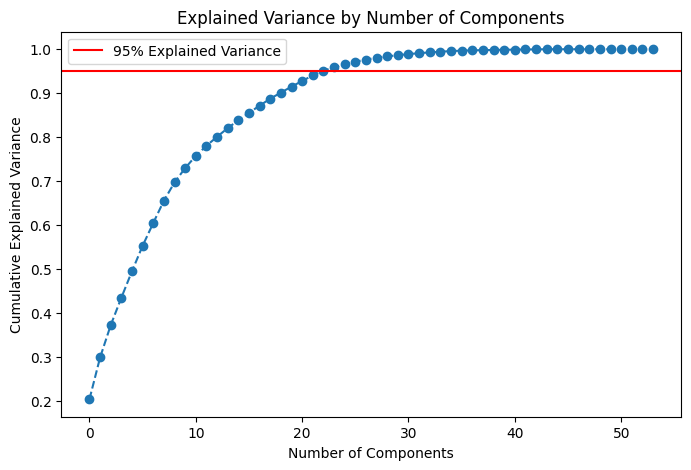

In [ ]:
pca = PCA().fit(X_train_preprocessed)

# Plot the cumulative sum of explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')

# Draw line at 90% of explained variance, for example
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.legend()

plt.show()

Based on the graph above, I decided to choose 12 PCA components to reduce dimensionality, It explains 80%+ variance.

In [ ]:
pca = PCA(n_components=12)

# Fit PCA on the training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_test_pca = pca.transform(X_test_preprocessed)

**Below, I subsampled from training set to do model comparison and selection to increase efficiency and for demonstration, but if allowed, it's better to use the entire training set so that each model can learn more information and patterns and we can assess the models more accurately.**

In [ ]:
# Subsample again from training set to increase time efficiency
X_train_pca_sub, _, y_train_sub, _ = train_test_split(X_train_pca, y_train, test_size=0.3, random_state=42)

### Ridge Regression

In [ ]:
# Try Ridge Regression on subsample of training set for hyperparameter tuning to check performance
ridge = Ridge(solver='svd')
ridge_param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV on the subsampled training data
ridge_grid_search.fit(X_train_pca_sub, y_train_sub)

# Output the best alpha value found
print("Best alpha:", ridge_grid_search.best_params_['alpha'])

ridge_best_mse = -ridge_grid_search.best_score_
ridge_best_rmse = np.sqrt(ridge_best_mse)

print("Best Ridge RMSE from CV:", ridge_best_rmse)


Best alpha: 1000.0
Best Ridge RMSE from CV: 0.03512274198227533


### KNN

In [ ]:
# Try KNN on subsample of training set for hyperparameter tuning to check performance
knn = KNeighborsRegressor()

knn_param_grid = {
    'n_neighbors': [3, 5, 10],
    }

knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

knn_grid_search.fit(X_train_pca_sub, y_train_sub)

print("Best parameters:", knn_grid_search.best_params_)

knn_best_mse = -knn_grid_search.best_score_
knn_best_rmse = np.sqrt(knn_best_mse)
print("Best KNN RMSE from CV:", knn_best_rmse)

Best parameters: {'n_neighbors': 10}
Best KNN RMSE from CV: 0.03436548633246997


### Gradient Boosting

In [ ]:
# Try GradientBoosting on subsample of training set for hyperparameter tuning to check performance
gb = GradientBoostingRegressor(random_state=42)

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [4, 6, 8]
}

gb_grid_search = GridSearchCV(estimator=gb, param_grid=gb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

gb_grid_search.fit(X_train_pca_sub, y_train_sub)

best_params = gb_grid_search.best_params_
print("Best parameters:", best_params)

gb_best_mse = -gb_grid_search.best_score_
gb_best_rmse = np.sqrt(gb_best_mse)

print("Best GradientBoosting RMSE from CV:", gb_best_rmse)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 300}
Best GradientBoosting RMSE from CV: 0.0317844634996706


The best GradientBoosting model has the lowest RMSE from CV compared to Ridge Regression and KNN, therefore I chose this model to proceed.

### Train the best GB model with best hyperparameters on the entire training set

In [ ]:
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_samples_split': 4,
    'n_estimators': 300
}

gb_final = GradientBoostingRegressor(random_state=42, **best_params)

gb_final.fit(X_train_pca, y_train)

GradientBoostingRegressor(max_depth=5, min_samples_split=4, n_estimators=300,
                          random_state=42)

## Model Evaluation

In [ ]:
gb_y_pred = gb_final.predict(X_test_pca)

# Calculate MSE and RMSE for the test set
gb_test_mse = mean_squared_error(y_test, gb_y_pred)
gb_test_rmse = np.sqrt(gb_test_mse)

print("Gradient Boosting Regressor RMSE on Test Set:", gb_test_rmse)

Gradient Boosting Regressor RMSE on Test Set: 0.027994186869295595


**The RMSE on test set is even smaller than the RMSE from CV, indicating that this model isn't overfitting and performs well on unseen data.**

## Prediction

### Process data from Holdout dataset

In [ ]:
# Function used for this section
def check_date_format(date_str):
    """
    This function checks the values in the column to see whether they have the correct format.
    """
    try:
        # Attempt to parse the date string using the specified format
        datetime.strptime(date_str, '%b-%y')
        return True  # The format matches
    except ValueError:
        return False  # The format does not match

In [ ]:
df_holdout = pd.read_csv('Holdout for Testing.csv')
df_holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      0 non-null      float64
 1   X2      80000 non-null  int64  
 2   X3      80000 non-null  int64  
 3   X4      80000 non-null  object 
 4   X5      80000 non-null  object 
 5   X6      80000 non-null  object 
 6   X7      80000 non-null  object 
 7   X8      80000 non-null  object 
 8   X9      80000 non-null  object 
 9   X10     75606 non-null  object 
 10  X11     75618 non-null  object 
 11  X12     80000 non-null  object 
 12  X13     80000 non-null  float64
 13  X14     80000 non-null  object 
 14  X15     80000 non-null  object 
 15  X16     15 non-null     object 
 16  X17     80000 non-null  object 
 17  X18     80000 non-null  object 
 18  X19     80000 non-null  object 
 19  X20     80000 non-null  object 
 20  X21     80000 non-null  float64
 21  X22     80000 non-null  int64  
 22

In [ ]:
df_holdout['X16'] = df_holdout['X16'].replace(r'^\s*$', np.nan, regex=True)
df_holdout['Provided loan reasons'] = np.where(df_holdout['X16'].isna(), 0, 1)
df_holdout.drop('X16', axis=1, inplace=True)

In [ ]:
X25_categories = ['Very recent', 'Some time ago', 'Long time ago', 'No delinquency']

df_holdout['delinquency_recency'] = pd.qcut(df_holdout['X25'].dropna(),
                                     q=3,
                                     labels=X25_categories[:-1])

df_holdout['delinquency_recency'] = pd.Categorical(df_holdout['delinquency_recency'], categories=X25_categories, ordered=True)

df_holdout['delinquency_recency'].fillna('No delinquency', inplace=True)

df_holdout.drop('X25', axis=1, inplace=True)

In [ ]:
public_record_categories = ['Very recent', 'Some time ago', 'Long time ago', 'No public record']

df_holdout['public_record_recency'] = pd.qcut(df_holdout['X26'].dropna(),
                                       q=3,
                                       labels=public_record_categories[:-1])

df_holdout['public_record_recency'] = pd.Categorical(df_holdout['public_record_recency'], categories=public_record_categories, ordered=True)

df_holdout['public_record_recency'].fillna('No public record', inplace=True)

df_holdout.drop('X26', axis=1, inplace=True)

In [ ]:
df_holdout.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df_holdout = df_holdout.drop(['X1', 'X3', 'X9', 'X15', 'X19'], axis=1)
df_holdout.dropna(inplace=True)

In [ ]:
len(df_holdout)

75543

In [ ]:
# Apply the check to each value in the column and count how many don't match the format
count_mismatch = df_holdout['X23'].apply(lambda x: not check_date_format(x)).sum()

print(f"Number of values not following the '%b-%y' format: {count_mismatch}")

Number of values not following the '%b-%y' format: 32823


Since almost half of the values in X23(Date the borrower's earliest reported credit line was opened), lack the year, I cannot create a new column that represents days_since_earliest_credit_line_opened. Therefore I could only drop it.

In [ ]:
df_holdout.drop('X23', axis=1, inplace=True)

In [ ]:
df_holdout = df_holdout.drop(['X10'], axis=1)

df_holdout['X11'] = df_holdout['X11'].apply(map_years_employed_to_category)

X12_cate_counts = df_holdout['X12'].value_counts()

less_frequent_categories = X12_cate_counts[X12_cate_counts < 80].index

df_holdout = df_holdout[~df_holdout['X12'].isin(less_frequent_categories)]

In [ ]:
X17_cate_counts = df_holdout['X17'].value_counts()

X17_less_frequent_categories = X17_cate_counts[X17_cate_counts < 200].index

df_holdout = df_holdout[~df_holdout['X17'].isin(X17_less_frequent_categories)]

df_holdout.drop('X18', axis=1, inplace=True)
df_holdout.drop('X20', axis=1, inplace=True)

df_holdout['X4'] = df_holdout['X4'].replace('[\$,]', '', regex=True).astype(float)
df_holdout['X5'] = df_holdout['X5'].replace('[\$,]', '', regex=True).astype(float)
df_holdout['X6'] = df_holdout['X6'].replace('[\$,]', '', regex=True).astype(float)
df_holdout['X30'] = df_holdout['X30'].str.rstrip('%').astype(float) / 100

In [ ]:
pd.set_option('display.max_columns', None)
df_holdout.head()

,X2,X4,X5,X6,X7,X8,X11,X12,X13,X14,X17,X21,X22,X24,X27,X28,X29,X30,X31,X32,Provided loan reasons,delinquency_recency,public_record_recency
0,44409194,6000.0,6000.0,6000.0,36 months,C,10+ years,MORTGAGE,68000.0,VERIFIED - income,debt_consolidation,28.31,0,1,18,0,19861,0.645,33,f,0,Some time ago,No public record
1,44017917,24000.0,24000.0,24000.0,36 months,A,5 years to 10 years,RENT,110480.0,VERIFIED - income,debt_consolidation,16.03,0,1,12,0,17001,0.262,36,w,0,No delinquency,No public record
2,44259158,35000.0,35000.0,35000.0,36 months,C,10+ years,MORTGAGE,86000.0,VERIFIED - income,debt_consolidation,32.49,0,0,16,0,25797,0.499,33,w,0,No delinquency,No public record
3,44429213,10000.0,10000.0,10000.0,60 months,D,10+ years,RENT,30000.0,VERIFIED - income source,debt_consolidation,32.96,0,1,13,1,9586,0.438,21,w,0,No delinquency,Long time ago
4,44299188,24000.0,24000.0,24000.0,60 months,B,10+ years,MORTGAGE,82500.0,VERIFIED - income,debt_consolidation,31.03,0,0,27,0,31842,0.413,43,w,0,Long time ago,No public record


In [ ]:
categorical_cols = df_holdout.select_dtypes(include=['object', 'category']).columns
numerical_cols = df_holdout.select_dtypes(include=['float64', 'int']).columns

In [ ]:
numerical_cols = numerical_cols.drop('X2')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

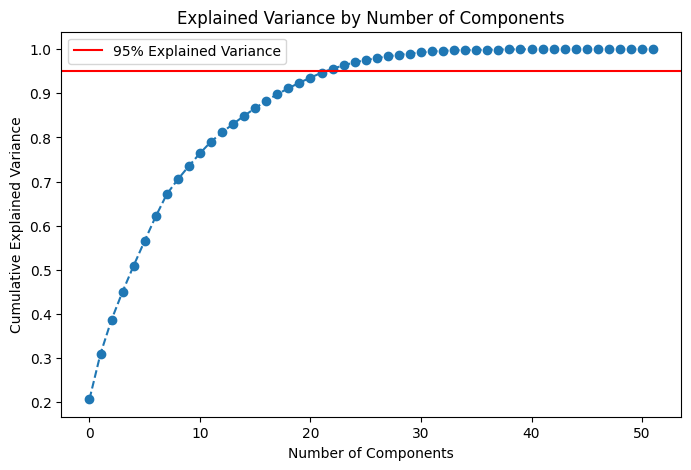

In [ ]:
identifier = df_holdout['X2']

X_holdout = df_holdout.drop('X2', axis=1)
X_holdout_preprocessed = preprocessor.fit_transform(X_holdout)

pca = PCA().fit(X_holdout_preprocessed)

# Plot the cumulative sum of explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')

# Draw line at 90% of explained variance, for example
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.legend()

plt.show()

Again, to be consistent, I chose 12 PCA components that explain 80%+ variance in the data.

In [ ]:
pca = PCA(n_components=12)
X_holdout_pca = pca.fit_transform(X_holdout_preprocessed)

In [ ]:
gb_holdout_predictions = gb_final.predict(X_holdout_pca)

results_df = pd.DataFrame(gb_holdout_predictions, columns=['Predicted Values'])
results_df = pd.DataFrame({'Unique Loan ID': identifier, 'Predicted Value': gb_holdout_predictions})

# Save the predictions to a CSV file
results_df.to_csv('Loan Results from Yezi Liu.csv', index=False)

Brief Write-Up - compare the pros and cons of the modeling techniques I used:

Ridge Regression provides coefficients for features to increase model interpretability and is computational efficient. But it assumes a linear relationship between predictors and the target variable and therefore is less flexible in modeling complex interactions between features. KNN is known for its simplicity and flexibility that captures complex nonlinear relationships without the need for a specific functional form. But it's computationally intensive, sensitive to data size, and subjective to the curse of dimensionality. Gradient Boosting can model complex nonlinear relationships, provide superior predictive accuracy, and is more robust to outliers. But it's much more computationally intensive than previous two models and is more complex to interpret than linear models due to its ensemble nature and the sequential corrections of residuals. In my case, Gradient Boosting's ability to model complex relationships and interactions between features make it perform slightly better than the other two models.
